<span style="font-weight: bold;  font-size: 20pt">Topic Modeling(Classification)</span>

<span style="font-weight: bold;  font-size: 15pt">Preprocessing</span>

In [1]:
from konlpy.tag import Okt
from konlpy.tag import Kkma
from konlpy.tag import Twitter
from konlpy.utils import pprint

from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer

import csv
import itertools

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import gensim.corpora as corpora
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import TaggedDocument

In [3]:
# 크롤링한 기사 데이터를 가져온다
df = pd.read_csv('data/article.csv')

# 모든 데이터 타입은 str로 만들어 준다
df = df.astype(str)

In [4]:
# 중복 행 데이터 제거
df.drop_duplicates(subset=['title', 'article'], inplace=True)

- <span style="font-weight: bold;  font-size: 13pt">기사 제목과 기사 원문을 article column으로 모두 합쳐준후, 한 문장이 하나의 row가 되도록 전처리</span>

In [5]:
df['article_split'] = df['article'].apply(lambda sentence : sentence.split('.'))

In [6]:
dic = {'article':[],
      'category':[],}

for row in df.iterrows():
    dic['article'].append(row[1]['title'])
    dic['category'].append(row[1]['category'])
    for sentence in row[1]['article_split']:
        dic['article'].append(sentence)
        dic['category'].append(row[1]['category'])

In [7]:
df = pd.DataFrame.from_dict(dic)

In [8]:
df.tail()

,article,category
173983,씨제이몰의 ‘신발 정리대’(9천원)는 종전에 한 켤레를 넣을 수 있던 공간에 두 ...,travel
173984,겨울에 신던 부츠를 깔끔하게 보관하려면 씨제이몰에서 판매하는 ‘부츠 원형 보존 보...,travel
173985,가죽이나 스웨이드 부츠 안에 넣어두면 모양이 흐트러지지 않게 보관할 수 있을 뿐 ...,travel
173986,"인터파크에서 판매하고 있는 ‘신발속 습기, 세균, 냄새제거 탈취제 발고랑’(1만75...",travel
173987,윤영미 기자,travel


- <span style="font-weight: bold;  font-size: 13pt">단어 / 문장 전처리</span>

In [9]:
# 이름, 고유명사는 하나로 통일
df['article'] = df['article'].replace('문 정권', '문재인 정권')
df['article'] = df['article'].replace('문 정부', '문재인 정부')
df['article'] = df['article'].replace('문 대통령', '문재인 대통령')
df['article'] = df['article'].replace('도널드 트럼프', '트럼프')
df['article'] = df['article'].replace('KT', '케이티')
df['article'] = df['article'].replace('SK', '에스케이')

df['article'] = df['article'].replace('승', '승리')
df['article'] = df['article'].replace('TV', '티프이')



# 한·미 같은 단어는 한국 미국으로 나타내었다
df['article'] = df['article'].replace("한[-·]미", '한국 미국')
df['article'] = df['article'].replace("한미", '한국 미국')
df['article'] = df['article'].replace("북[-·]미", '북한 미국')
df['article'] = df['article'].replace("북미", '북한 미국')


# 시간, 날짜, 수치 등은 모두 제거(10월, 4일, 수요일, 4시, 40%)
df['article'] = df['article'].replace('[0-9]{1,10}[가-힣\%]{1,10}', ' ',regex=True)
df['article'] = df['article'].replace('[가-힣]요일', ' ', regex=True)

# [영상], [포토] 등 단어 제거
df['article'] = df['article'].replace("\[.{1,20}\]",' ',regex=True)

# 뒤에 기자이름은 없앤다
df['article'] = df['article'].replace('[가-힣]{1,4} 기자',' ',regex=True)

# 한글만 텍스트로 남긴다
df['article'] = df['article'].replace('[^가-힣\s]',' ',regex=True)

In [10]:
df[df.columns] = df.apply(lambda x: x.str.strip())

In [11]:
# 중복 행 데이터 제거
df.drop_duplicates(subset=['article'], inplace=True)

In [12]:
df.tail()

,article,category
173982,또 옥션에 나와 있는 커버 신발장 은 신발장 겉면에 폴리에스테르 소재의 지퍼...,travel
173983,씨제이몰의 신발 정리대 는 종전에 한 켤레를 넣을 수 있던 공간에 두 켤레를...,travel
173984,겨울에 신던 부츠를 깔끔하게 보관하려면 씨제이몰에서 판매하는 부츠 원형 보존 보관...,travel
173985,가죽이나 스웨이드 부츠 안에 넣어두면 모양이 흐트러지지 않게 보관할 수 있을 뿐 아...,travel
173986,인터파크에서 판매하고 있는 신발속 습기 세균 냄새제거 탈취제 발고랑 은...,travel


- <span style="font-weight: bold;  font-size: 13pt">Null data 확인</span>

In [29]:
df.isnull().values.any()

False

- <span style="font-weight: bold;  font-size: 13pt">형태소 분석 / Konlp</span>


     - 품사 태깅

In [14]:
okt = Okt()
df['article_okt'] = df['article'].map(lambda sentence:okt.morphs(sentence))

In [15]:
df.tail()

,article,category,article_okt
173982,또 옥션에 나와 있는 커버 신발장 은 신발장 겉면에 폴리에스테르 소재의 지퍼...,travel,"[또, 옥션, 에, 나와, 있는, 커버, 신발장, 은, 신발장, 겉면, 에, 폴리에..."
173983,씨제이몰의 신발 정리대 는 종전에 한 켤레를 넣을 수 있던 공간에 두 켤레를...,travel,"[씨제이, 몰의, 신발, 정리, 대, 는, 종전, 에, 한, 켤레, 를, 넣을, 수..."
173984,겨울에 신던 부츠를 깔끔하게 보관하려면 씨제이몰에서 판매하는 부츠 원형 보존 보관...,travel,"[겨울, 에, 신던, 부츠, 를, 깔끔하게, 보관, 하려면, 씨제이, 몰에서, 판매..."
173985,가죽이나 스웨이드 부츠 안에 넣어두면 모양이 흐트러지지 않게 보관할 수 있을 뿐 아...,travel,"[가죽, 이나, 스웨이드, 부츠, 안, 에, 넣어, 두면, 모양, 이, 흐트러지, ..."
173986,인터파크에서 판매하고 있는 신발속 습기 세균 냄새제거 탈취제 발고랑 은...,travel,"[인터파크, 에서, 판매, 하고, 있는, 신발, 속, 습기, 세균, 냄새, 제거, ..."


- <span style="font-weight: bold;  font-size: 13pt">stopwords 제거</span>


In [17]:
df['article_okt_sentence'] = df['article_okt'].apply(lambda word : (' ').join(word))

In [19]:
df['word_tagging'] = df['article_okt_sentence'].apply(lambda sentence: okt.pos(sentence, norm=True, stem=True))

In [23]:
# stopword 외부에서 가져온것
file = open('data/stopwords-ko.txt', 'r')
reader = csv.reader(file)
allRows = [row for row in reader]

# flatten list
stopwords = list(itertools.chain(*allRows))

# 내가 stopword를 추가한것
my_stopwords = ['것', '했다', '하겠습니다', '또', '있다', '다', '하는', '된', '의', '그', '해야', '한다고', \
                  '로부터', '등', '했는데', '하겠느냐', '데', '며', '하신', '고', '위해', '라며', '가겠다', '있는', '보인다',\
               '대해', '못', '됐다', '안', '되었기', '수', '할', '해','뭘', '는', '한다','이나']

stopwords = list(set(stopwords + my_stopwords))

In [33]:
def morpheme(row):
    '''
    param : [(word1,tag1), (word2,tag2),...] 형태의 row list(dataframe) 
    return : 품사 tagging한 컬럼에서 조사, 어미, 감탄사, 이모티콘, punctuation을 제거해준 list
    
    조사와 감탄사등 필요없는 토큰은 제거해주고 제거해준 list를 반환해주는 함수
    '''
    tagging_ls = []
    for word in row:
        if (word[1] != 'Josa') and (word[1] != 'Suffix') and (word[1] != 'Modifier') and (word[1] != 'Determiner') and \
        (word[1] != 'Exclamation') and (word[1] != 'Eomi') and (word[1] != 'PreEomi') and (word[1] != 'Punctuation'):
            tagging_ls.append(word)
            
    return tagging_ls


def remove_stopwords(row):
    '''
    param : [(word1,tag1), (word2,tag2),...] 형태의 row list(dataframe)
    return : stopwords를 제거한 품사 tagging list 반환
    
    불용어를 제거해준 list 반환해주는 함수
    '''
    no_stopwords_ls = []
    for word in row:
        if word[0] not in stopwords:
            no_stopwords_ls.append(word)
            
    return no_stopwords_ls


def word_join(row):
    '''
    param : [(word1,tag1), (word2,tag2),...] 형태의 row list(dataframe)
    return : 불필요한 품사를 제거하고 stopword를 제거한 문장 string 반환
    '''
    sentence = ''
    
    for word in row:
        sentence += word[0] + ' '
    return sentence.strip()

In [27]:
df['article_modified_pos'] = df['word_tagging'].apply(lambda row: morpheme(row))

In [31]:
df['article_modified_pos'] = df['article_modified_pos'].apply(lambda row: remove_stopwords(row))

In [35]:
df['modified_article_sentence'] = df['article_modified_pos'].apply(lambda row: word_join(row))

In [36]:
df.tail()

,article,category,article_okt,article_okt_sentence,word_tagging,article_modified_pos,modified_article_sentence
173982,또 옥션에 나와 있는 커버 신발장 은 신발장 겉면에 폴리에스테르 소재의 지퍼...,travel,"[또, 옥션, 에, 나와, 있는, 커버, 신발장, 은, 신발장, 겉면, 에, 폴리에...",또 옥션 에 나와 있는 커버 신발장 은 신발장 겉면 에 폴리에스테르 소재 의 지퍼 ...,"[(또, Noun), (옥션, Noun), (에, Josa), (나오다, Verb)...","[(옥션, Noun), (나오다, Verb), (커버, Noun), (신발장, No...",옥션 나오다 커버 신발장 은 신발장 겉 폴리에스테르 소재 지퍼 식 커버 가다 덮이다...
173983,씨제이몰의 신발 정리대 는 종전에 한 켤레를 넣을 수 있던 공간에 두 켤레를...,travel,"[씨제이, 몰의, 신발, 정리, 대, 는, 종전, 에, 한, 켤레, 를, 넣을, 수...",씨제이 몰의 신발 정리 대 는 종전 에 한 켤레 를 넣을 수 있던 공간 에 두 켤레...,"[(씨제이, Noun), (몰다, Verb), (신발, Noun), (정리, Nou...","[(씨제이, Noun), (몰다, Verb), (신발, Noun), (정리, Nou...",씨제이 몰다 신발 정리 대다 늘다 종전 하다 켤레 넣다 공간 두 켤레 넣다 신발장 ...
173984,겨울에 신던 부츠를 깔끔하게 보관하려면 씨제이몰에서 판매하는 부츠 원형 보존 보관...,travel,"[겨울, 에, 신던, 부츠, 를, 깔끔하게, 보관, 하려면, 씨제이, 몰에서, 판매...",겨울 에 신던 부츠 를 깔끔하게 보관 하려면 씨제이 몰에서 판매 하는 부츠 원형 보...,"[(겨울, Noun), (에, Josa), (신다, Verb), (부츠, Noun)...","[(겨울, Noun), (신다, Verb), (부츠, Noun), (깔끔하다, Ad...",겨울 신다 부츠 깔끔하다 보관 하다 씨제이 몰다 판매 하다 부츠 원형 보존 보관 대...
173985,가죽이나 스웨이드 부츠 안에 넣어두면 모양이 흐트러지지 않게 보관할 수 있을 뿐 아...,travel,"[가죽, 이나, 스웨이드, 부츠, 안, 에, 넣어, 두면, 모양, 이, 흐트러지, ...",가죽 이나 스웨이드 부츠 안 에 넣어 두면 모양 이 흐트러지 지 않게 보 관할 수 ...,"[(가죽, Noun), (이나, Noun), (스웨이드, Noun), (부츠, No...","[(가죽, Noun), (이나, Noun), (스웨이드, Noun), (부츠, No...",가죽 이나 스웨이드 부츠 넣다 두다 모양 흐트러 지다 않다 보 관할 뿐 아니다 숯 ...
173986,인터파크에서 판매하고 있는 신발속 습기 세균 냄새제거 탈취제 발고랑 은...,travel,"[인터파크, 에서, 판매, 하고, 있는, 신발, 속, 습기, 세균, 냄새, 제거, ...",인터파크 에서 판매 하고 있는 신발 속 습기 세균 냄새 제거 탈취 제 발 고랑 은 ...,"[(인터파크, Noun), (에서, Josa), (판매, Noun), (하다, Ve...","[(인터파크, Noun), (판매, Noun), (하다, Verb), (신발, No...",인터파크 판매 하다 신발 속 습기 세균 냄새 제거 탈취 발 고랑 은 신발 내부 세균...


In [ ]:
df = df[df['modified_article_sentence','article_modified_pos','category']]
df.to_pickle('morphs_article.pkl')

각 카테고리별 데이터 갯수 분포

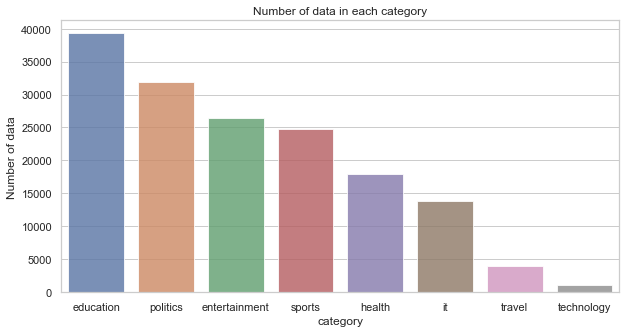

In [5]:
category_count  = df['category'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(category_count.index, category_count.values, alpha=0.8)
plt.title('Number of data in each category')
plt.ylabel('Number of data', fontsize=12)
plt.xlabel('category', fontsize=12)
plt.show()

카테고리 별로 비중 있는 단어 뽑아보기(TF-IDF)

In [28]:
df['sentence_length'] = df['article_modified_pos'].apply(lambda sentence:len(sentence))

In [30]:
df = df[df['sentence_length']>0]
df.reset_index(inplace=True)

In [31]:
df = df[['modified_article_sentence','article_modified_pos','category']]

In [32]:
df.head()

,modified_article_sentence,article_modified_pos,category
0,땀 만 뻘뻘 머리 가슴 쓰다 체육,"[(땀, Noun), (만, Noun), (뻘뻘, Noun), (머리, Noun),...",education
1,주자 가다 공 뛰다 아웃 당하다 심판 시그널 어떻다 주다 좋다 가다 열심히 뛰다 앞...,"[(주자, Noun), (가다, Verb), (공, Noun), (뛰다, Verb)...",education
2,들다 은 고개 끄덕 심판 시그널 동작 구호 연습 하다,"[(들다, Verb), (은, Noun), (고개, Noun), (끄덕, Noun)...",education
3,지난달 오후 경기도 수원 곡 반초 모이다 학생 들다 땀 뻘뻘 흘리다 티볼 형 막대기...,"[(지난달, Noun), (오후, Noun), (경기도, Noun), (수원, No...",education
4,기본 적 인 수비 타격 외 포지션 역할 필요하다 능력 세이프 오다 아웃 심판 시그널...,"[(기본, Noun), (적, Noun), (인, Noun), (수비, Noun),...",education


In [2]:
df.to_pickle('data/morphs_article.pkl')

In [3]:
df.tail()

,modified_article_sentence,article_modified_pos,category
159114,옥션 나오다 커버 신발장 은 신발장 겉 폴리에스테르 소재 지퍼 식 커버 가다 덮이다...,"[(옥션, Noun), (나오다, Verb), (커버, Noun), (신발장, No...",travel
159115,씨제이 몰다 신발 정리 대다 늘다 종전 하다 켤레 넣다 공간 두 켤레 넣다 신발장 ...,"[(씨제이, Noun), (몰다, Verb), (신발, Noun), (정리, Nou...",travel
159116,겨울 신다 부츠 깔끔하다 보관 하다 씨제이 몰다 판매 하다 부츠 원형 보존 보관 대...,"[(겨울, Noun), (신다, Verb), (부츠, Noun), (깔끔하다, Ad...",travel
159117,가죽 이나 스웨이드 부츠 넣다 두다 모양 흐트러 지다 않다 보 관할 뿐 아니다 숯 ...,"[(가죽, Noun), (이나, Noun), (스웨이드, Noun), (부츠, No...",travel
159118,인터파크 판매 하다 신발 속 습기 세균 냄새 제거 탈취 발 고랑 은 신발 내부 세균...,"[(인터파크, Noun), (판매, Noun), (하다, Verb), (신발, No...",travel


In [67]:
def extract_rows(category, df=df, column='modified_article_sentence'):
    '''
    params df : dataframe 
    params category : 뽑고자 하는 행의 특정한 카테고리 이름 
    params column : 뽑고자 하는 컬럼
    
    특정한 카테고리의 열을 뽑을때
    '''
    return df[df["category"]==category][column]
    

def extract_high_tfidf_word(category, top_n=50, low_n=50):
    sentence_ls = extract_rows(category)
    vectorizer = TfidfVectorizer(smooth_idf=True)
    tv_category = vectorizer.fit_transform(sentence_ls)
    
    word_tfidf_value_list = []
    
    dense_matrix = tv_category.todense()
    word_to_index = vectorizer.vocabulary_
    
    num_word = dense_matrix.shape[1]
    
    for idx in range(num_word):
        word_tfidf_value_list.append((idx, dense_matrix[:, idx].mean()))

    # sort index by tfidf value
    
    word_tfidf_value_list = np.array([idx for idx, tfidf_value in sorted(word_tfidf_value_list, key=lambda word_tfidf_value_list: word_tfidf_value_list[1])])
    
    # extract word
    top_n_word = word_tfidf_value_list[:top_n]
    low_n_word = word_tfidf_value_list[-low_n:]
    
    top_n_result = []
    low_n_result = []
    
    for word_index in top_n_word:
        for word, idx in word_to_index.items():
            if idx == word_index:
                top_n_result.append(word)
                
    for word_index in low_n_word:
        for word, idx in word_to_index.items():
            if idx == word_index:
                low_n_result.append(word)
                
                
    return top_n_result, low_n_result


# # 카테고리별로 데이터를 따로 저장해놓는다
# education = extract_rows('education')
# politics = extract_rows('politics')
# entertainment = extract_rows('entertainment')
# sports = extract_rows('sports')
# health = extract_rows('health')
# it = extract_rows('it')
# travel = extract_rows('travel')
# technology = extract_rows('technology')

# # 각 카테고리 별로 tf-idf로 단어 비중확인

# edu_vectorizer = TfidfVectorizer(smooth_idf=True)
# politics_vectorizer = TfidfVectorizer(smooth_idf=True)
# entertainment_vectorizer = TfidfVectorizer(smooth_idf=True)
# sports_vectorizer = TfidfVectorizer(smooth_idf=True)
# health_vectorizer = TfidfVectorizer(smooth_idf=True)
# it_vectorizer = TfidfVectorizer(smooth_idf=True)
# travel_vectorizer = TfidfVectorizer(smooth_idf=True)
# technology_vectorizer = TfidfVectorizer(smooth_idf=True)


# tv_education = edu_vectorizer.fit_transform(education)
# tv_politics = politics_vectorizer.fit_transform(politics)
# tv_entertainment = entertainment_vectorizer.fit_transform(entertainment)
# tv_sports = sports_vectorizer.fit_transform(sports)
# tv_health = health_vectorizer.fit_transform(health)
# tv_it = it_vectorizer.fit_transform(it)
# tv_travel = travel_vectorizer.fit_transform(travel)
# tv_technology = technology_vectorizer.fit_transform(technology)


In [68]:
edu_top_n, edu_low_n = extract_high_tfidf_word('education')

In [69]:
edu_top_n

['매스미디어',
 '음성학',
 '대금',
 '문화영',
 '커뮤니케이션학',
 '면세점',
 '윈드서핑',
 '의료관광',
 '카지노',
 '크루즈',
 '경주대',
 '극동대',
 '김포대',
 '농협대',
 '서일대',
 '세한대',
 '송곡',
 '송호',
 '여주대',
 '영서',
 '한영신학대',
 '기계설계',
 '기동',
 '거여',
 '거초',
 '명진',
 '상문고',
 '성호',
 '영남권',
 '오산고',
 '인중',
 '가발',
 '각막',
 '고동',
 '넓적다리',
 '복벽',
 '분절',
 '상박',
 '안구',
 '정강이',
 '췌장',
 '콘택트렌즈',
 '콩팥',
 '판막',
 '페이스메이커',
 '후두',
 '산수',
 '게트림',
 '깨부수다',
 '망나니']

In [70]:
edu_low_n

['통해',
 '만들다',
 '영역',
 '교육청',
 '서울',
 '시험',
 '이렇다',
 '영어',
 '활동',
 '어떻다',
 '청소년',
 '경우',
 '선발',
 '서다',
 '평가',
 '대한',
 '자다',
 '그렇다',
 '사회',
 '성적',
 '사람',
 '모집',
 '수업',
 '때문',
 '수능',
 '좋다',
 '지원',
 '공부',
 '문제',
 '생각',
 '많다',
 '돼다',
 '전형',
 '아니다',
 '받다',
 '교사',
 '없다',
 '이다',
 '대학',
 '교육',
 '보다',
 '않다',
 '오다',
 '학교',
 '학생',
 '되다',
 '가다',
 '늘다',
 '들다',
 '하다']

In [35]:
edu_vectorizer.vocabulary_

{'뻘뻘': 8942,
 '머리': 6089,
 '가슴': 115,
 '쓰다': 11659,
 '체육': 18416,
 '주자': 17222,
 '가다': 36,
 '뛰다': 5390,
 '아웃': 11806,
 '당하다': 4322,
 '심판': 11575,
 '시그널': 11054,
 '어떻다': 12364,
 '주다': 17153,
 '좋다': 17096,
 '열심히': 12985,
 '크다': 19240,
 '소리': 10256,
 '받다': 7344,
 '기분': 2576,
 '명수': 6267,
 '스포츠': 10959,
 '강사': 427,
 '동작': 5003,
 '취하': 18858,
 '평소': 20132,
 '명확하다': 6301,
 '크게': 19236,
 '외치다': 13529,
 '상황': 9516,
 '따르다': 5306,
 '상대방': 9404,
 '감정': 353,
 '상하': 9504,
 '지다': 17510,
 '않다': 12019,
 '가볍다': 93,
 '손동작': 10403,
 '판정': 19935,
 '하다': 20595,
 '예의': 13184,
 '알다': 12023,
 '들다': 5186,
 '고개': 1095,
 '끄덕': 3207,
 '구호': 1964,
 '연습': 12912,
 '지난달': 17498,
 '오후': 13335,
 '경기도': 901,
 '수원': 10650,
 '반초': 7333,
 '모이다': 6364,
 '학생': 20712,
 '흘리다': 21993,
 '티볼': 19814,
 '막대기': 5835,
 '놓다': 3864,
 '방망이': 7466,
 '치다': 18883,
 '종목': 17057,
 '야구': 12191,
 '오다': 13218,
 '변형': 7917,
 '훈련': 21906,
 '기본': 2573,
 '수비': 10589,
 '타격': 19312,
 '포지션': 20235,
 '역할': 12823,
 '필요하다': 20562,
 '능력': 3967,
 '세이프': 10

In [ ]:
df.

In [25]:
edu_vectorizer.vocabulary_

{'뻘뻘': 8942,
 '머리': 6089,
 '가슴': 115,
 '쓰다': 11659,
 '체육': 18416,
 '주자': 17222,
 '가다': 36,
 '뛰다': 5390,
 '아웃': 11806,
 '당하다': 4322,
 '심판': 11575,
 '시그널': 11054,
 '어떻다': 12364,
 '주다': 17153,
 '좋다': 17096,
 '열심히': 12985,
 '크다': 19240,
 '소리': 10256,
 '받다': 7344,
 '기분': 2576,
 '명수': 6267,
 '스포츠': 10959,
 '강사': 427,
 '동작': 5003,
 '취하': 18858,
 '평소': 20132,
 '명확하다': 6301,
 '크게': 19236,
 '외치다': 13529,
 '상황': 9516,
 '따르다': 5306,
 '상대방': 9404,
 '감정': 353,
 '상하': 9504,
 '지다': 17510,
 '않다': 12019,
 '가볍다': 93,
 '손동작': 10403,
 '판정': 19935,
 '하다': 20595,
 '예의': 13184,
 '알다': 12023,
 '들다': 5186,
 '고개': 1095,
 '끄덕': 3207,
 '구호': 1964,
 '연습': 12912,
 '지난달': 17498,
 '오후': 13335,
 '경기도': 901,
 '수원': 10650,
 '반초': 7333,
 '모이다': 6364,
 '학생': 20712,
 '흘리다': 21993,
 '티볼': 19814,
 '막대기': 5835,
 '놓다': 3864,
 '방망이': 7466,
 '치다': 18883,
 '종목': 17057,
 '야구': 12191,
 '오다': 13218,
 '변형': 7917,
 '훈련': 21906,
 '기본': 2573,
 '수비': 10589,
 '타격': 19312,
 '포지션': 20235,
 '역할': 12823,
 '필요하다': 20562,
 '능력': 3967,
 '세이프': 10

In [10]:
tv_education.todense().shape

(39290, 22061)

In [35]:

X = vectorizer.fit_transform(df['modified_article_sentence'].values.astype('U'))
X.shape # TF-IDF 행렬의 크기 확인

(159119, 50018)

In [36]:
dense = X.todense()


In [37]:
dense.shape

(159119, 50018)

In [38]:
dense

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
len(vectorizer.vocabulary_)

3649

In [23]:
tv_technology.todense().shape

(1111, 3649)

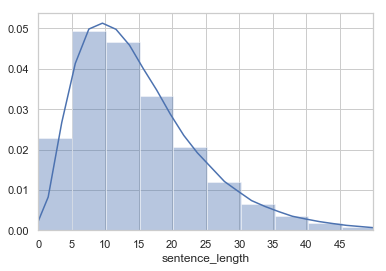

In [6]:
plt.xticks(np.arange(0, 50, step=5))
plt.xlim(0,50)
sns.distplot(df['sentence_length'])
# sns.countplot(df['sentence_length'])

In [54]:
def tag2word(row):
    '''
    param : [(word1,tag1), (word2,tag2),...] 형태의 row list(dataframe)
    return : {tag1 : [word_11, word_12, ..]
              tag2 : [word_21, word_22, ..]}
    '''
    tag_to_word = {'Noun':[],'Adjective':[]}

    
    for word_tag_ls in row:
        
        
        for idx, word_tag in enumerate(word_tag_ls):
            # 만약 tag_to_word 딕셔너리의 키에 특정 tag가 없으면 key로 tag를 넣어주고 value는 빈 리스트를 넣어준다
            if word_tag[1] not in list(tag_to_word.keys()):
                tag_to_word[word_tag[1]] = []

            # 만약 tag_to_word 딕셔너리의 특정 tag키의 value list중에 단어가 없으면 단어를 list
            if word_tag[0] not in tag_to_word[word_tag[1]]:
                tag_to_word[word_tag[1]].append(word_tag[0])


    return tag_to_word

In [55]:
tag2word = tag2word(df['article_modified_pos'])

In [56]:
tag2word

{'Noun': ['땀',
  '만',
  '뻘뻘',
  '머리',
  '가슴',
  '체육',
  '주자',
  '공',
  '아웃',
  '심판',
  '시그널',
  '앞',
  '소리',
  '기분',
  '거',
  '강',
  '명수',
  '스포츠',
  '강사',
  '동작',
  '취하',
  '평소',
  '크게',
  '상황',
  '상대방',
  '감정',
  '상하',
  '손동작',
  '판정',
  '게',
  '예의',
  '은',
  '고개',
  '끄덕',
  '구호',
  '연습',
  '지난달',
  '오후',
  '경기도',
  '수원',
  '곡',
  '반초',
  '학생',
  '티볼',
  '형',
  '막대기',
  '위',
  '방망이',
  '종목',
  '야구',
  '변형',
  '훈련',
  '기본',
  '적',
  '인',
  '수비',
  '타격',
  '외',
  '포지션',
  '역할',
  '능력',
  '세이프',
  '도',
  '여학생',
  '피구',
  '남학생',
  '축구',
  '교사',
  '대신',
  '학교',
  '급',
  '입시',
  '준비',
  '때문',
  '제대로',
  '활동',
  '더',
  '체력',
  '방점',
  '대안',
  '사례',
  '날',
  '진행',
  '프로그램',
  '융합',
  '교육',
  '사회',
  '협동조합',
  '개발',
  '운영',
  '스',
  '재배',
  '리',
  '리더십',
  '단체',
  '프로',
  '배구',
  '선수',
  '태권도',
  '상비군',
  '출신',
  '엘리트',
  '중간',
  '은퇴',
  '올해',
  '교육청',
  '꿈',
  '사업',
  '란',
  '마을',
  '공동체',
  '주체',
  '연',
  '계해',
  '스스로',
  '기획',
  '진로',
  '탐색',
  '경우',
  '무',
  '학년',
  '제로',
  '초등',
  '참여',


In [59]:
tag2word.keys()

dict_keys(['Noun', 'Adjective', 'Verb', 'Adverb', 'Conjunction', 'VerbPrefix'])

In [61]:
tot = 0
for key in tag2word.keys():
    tot += len(tag2word[key])
tot

50985

- <span style="font-weight: bold;  font-size: 13pt">soynlp</span>

    - unseen data를 구별하기 위해서

    - 기존 형태소 분석을 하기보다는 Cohesion Score를 활용하여 토크나이징을 진행해보았다
    - https://github.com/lovit/soynlp

In [6]:
sentences = df['modified_article_sentence']

word_extractor = WordExtractor(min_frequency=100,
    min_cohesion_forward=0.05, 
    min_right_branching_entropy=0.0
)
word_extractor.train(sentences) # list of str or like
words = word_extractor.extract()

training was done. used memory 1.493 Gbse memory 1.230 Gb
all cohesion probabilities was computed. # words = 8123
all branching entropies was computed # words = 165894
all accessor variety was computed # words = 165894


In [31]:
scores = {w:s.cohesion_forward for w,s in words.items()}

In [32]:
scores

{'누': 0,
 '테': 0,
 '꽃': 0,
 '흉': 0,
 '례': 0,
 '짧': 0,
 '옥': 0,
 '깨': 0,
 '맞': 0,
 '두': 0,
 '뜨': 0,
 '야': 0,
 '록': 0,
 '포': 0,
 '념': 0,
 '추': 0,
 '밥': 0,
 '범': 0,
 '쉬': 0,
 '셜': 0,
 '악': 0,
 '돋': 0,
 '곁': 0,
 '높': 0,
 '브': 0,
 '욱': 0,
 '블': 0,
 '괴': 0,
 '흐': 0,
 '점': 0,
 '턴': 0,
 '증': 0,
 '와': 0,
 '리': 0,
 '춰': 0,
 '키': 0,
 '흡': 0,
 '름': 0,
 '타': 0,
 '왜': 0,
 '페': 0,
 '쌍': 0,
 '댓': 0,
 '곳': 0,
 '뷔': 0,
 '은': 0,
 '습': 0,
 '넘': 0,
 '낭': 0,
 '채': 0,
 '쫓': 0,
 '달': 0,
 '즐': 0,
 '심': 0,
 '책': 0,
 '콤': 0,
 '프': 0,
 '콜': 0,
 '돌': 0,
 '좁': 0,
 '락': 0,
 '탤': 0,
 '링': 0,
 '떨': 0,
 '윌': 0,
 '먼': 0,
 '된': 0,
 '분': 0,
 '권': 0,
 '검': 0,
 '참': 0,
 '튼': 0,
 '쇠': 0,
 '즘': 0,
 '판': 0,
 '꺾': 0,
 '못': 0,
 '진': 0,
 '반': 0,
 '겁': 0,
 '째': 0,
 '율': 0,
 '결': 0,
 '률': 0,
 '또': 0,
 '뭔': 0,
 '충': 0,
 '붙': 0,
 '광': 0,
 '혀': 0,
 '무': 0,
 '얻': 0,
 '각': 0,
 '표': 0,
 '럴': 0,
 '올': 0,
 '쪽': 0,
 '희': 0,
 '역': 0,
 '하': 0,
 '앓': 0,
 '킹': 0,
 '닮': 0,
 '답': 0,
 '밤': 0,
 '박': 0,
 '샌': 0,
 '껏': 0,
 '잦': 0,
 '묻': 0,
 '냥': 0,
 

In [33]:
tokenizer = LTokenizer(scores=scores)

[('데이터', '마이닝을'), ('공부', '한다')]
['데이터', '마이닝을', '공부', '한다']


In [34]:
df['soynlp']= df['modified_article_sentence'].apply(lambda sentence: tokenizer.tokenize(sentence))

In [44]:
df.tail()

,article,category,article_pos,article_modified_pos,soynlp,article2,soynlp2
173982,또 옥션에 나와 있는 커버 신발장 은 신발장 겉면에 폴리에스테르 소재의 지퍼식 ...,travel,"[(또, Noun), (옥션, Noun), (에, Josa), (나와, Verb),...","[(옥션, Noun), (나와, Verb), (커버, Noun), (신발장, Nou...","[또, 옥션에, 나와, 있는, 커버, 신발장, 은, 신발장, 겉면에, 폴리에스테르,...",옥션 나와 커버 신발장 은 신발장 겉면 폴리에스테르 소재 지퍼 커버 덮여 있어 부츠...,"[옥션, 나와, 커버, 신발장, 은, 신발장, 겉면, 폴리에스테르, 소재, 지퍼, ..."
173983,씨제이몰의 신발 정리대 는 종전에 한 켤레를 넣을 수 있던 공간에 두 켤레를 넣을...,travel,"[(씨제이, Noun), (몰의, Verb), (신발, Noun), (정리, Nou...","[(씨제이, Noun), (몰의, Verb), (신발, Noun), (정리, Nou...","[씨제이몰의, 신발, 정리, 대, 는, 종전에, 한, 켤레를, 넣을, 수, 있던, ...",씨제이 몰의 신발 정리 종전 한 켤레 넣을 있던 공간 두 켤레 넣을 있도록 신발장 ...,"[씨제이, 몰의, 신발, 정리, 종전, 한, 켤레, 넣을, 있던, 공간, 두, 켤레..."
173984,겨울에 신던 부츠를 깔끔하게 보관하려면 씨제이몰에서 판매하는 부츠 원형 보존 보관대...,travel,"[(겨울, Noun), (에, Josa), (신던, Verb), (부츠, Noun)...","[(겨울, Noun), (신던, Verb), (부츠, Noun), (깔끔하게, Ad...","[겨울, 에, 신던, 부츠를, 깔끔하게, 보관, 하려면, 씨제이몰에서, 판매, 하는...",겨울 신던 부츠 깔끔하게 보관 하려면 씨제이 몰에서 판매 부츠 원형 보존 보관 이용...,"[겨울, 신던, 부츠, 깔끔하게, 보관, 하려, 면, 씨제이, 몰에서, 판매, 부츠..."
173985,가죽이나 스웨이드 부츠 안에 넣어두면 모양이 흐트러지지 않게 보관할 수 있을 뿐 아...,travel,"[(가죽, Noun), (이나, Josa), (스웨이드, Noun), (부츠, No...","[(가죽, Noun), (스웨이드, Noun), (부츠, Noun), (넣어, Ve...","[가죽이나, 스웨이드, 부츠, 안에, 넣어, 두면, 모양, 이, 흐트러지지, 않게,...",가죽 스웨이드 부츠 넣어 두면 모양 흐트러지 않게 보 관할 있을 뿐 아니라 숯 습제...,"[가죽, 스웨이드, 부츠, 넣어, 두면, 모양, 흐트러지, 않게, 보, 관할, 있을..."
173986,인터파크에서 판매하고 있는 신발속 습기 세균 냄새제거 탈취제 발고랑 은 신발 내...,travel,"[(인터파크, Noun), (에서, Josa), (판매, Noun), (하고, Jo...","[(인터파크, Noun), (판매, Noun), (신발, Noun), (속, Nou...","[인터, 파크에서, 판매, 하고, 있는, 신발속, 습기, 세균, 냄새제거, 탈취제,...",인터파크 판매 신발 속 습기 세균 냄새 제거 탈취 발 고랑 은 신발 내부 세균 흡착...,"[인터, 파크, 판매, 신발, 속, 습기, 세균, 냄새, 제거, 탈취, 발, 고랑,..."


<span style="font-weight: bold;  font-size: 15pt">카테고리별로 나온 단어 빈도수 확인</span>

In [85]:
def word_count_with_category(category):
    '''
    param : 단어 나온횟수를 알고싶은 카테고리 string
    return : dataframe(column : vals(단어), count(해당 단어가 나온 횟수))
    '''
    df_count = (df[df['category']==category]['modified_article_sentence'].str.split(expand=True)
              .stack()
              .value_counts()
              .rename_axis('vals')
              .reset_index(name='count'))
    
    return df_count


In [87]:
word_count_with_category('travel')

,vals,count
0,사람,179
1,말,157
2,곳,147
3,한,139
4,물,125
5,와인,119
6,마을,118
7,맛,110
8,고양이,108
9,된다,99


<span style="font-weight: bold;  font-size: 15pt">lasso 를 통한 특정한 카테고리에 영향을 많이 미치는 단어 확인</span>

In [5]:
vectorizer = TfidfVectorizer(smooth_idf=True)

X = vectorizer.fit_transform(df['modified_article_sentence'].values.astype('U'))
X.shape # TF-IDF 행렬의 크기 확인

(159179, 89002)

In [6]:
sparse_df = pd.SparseDataFrame(X, columns=vectorizer.get_feature_names())

In [15]:
sparse_df.tail()

,가가,가가린,가가와현,가가호호,가감,가객,가거나,가거도,가건물,가게,...,힘준다,힘줄,힘줘,힘차,힘차게,힘찬,힙겹,힙업,힙합,힝기스
159174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
word2index ={}
index2word = {}
for index, word in enumerate(sparse_df.columns):
    word2index[word] = index
    index2word[index] = word

In [8]:
word2index['정치']

68725

In [46]:
def similiar_category_word(category_word):

    rows, cols = X.nonzero()
    data = X.data

    #Create X_. tf matrix that dosen't have term category_word
    rows_, cols_, data_ = [], [], []
    for r, c, d in zip(rows, cols, data):
        if c == word2index[category_word]:
            continue
        rows_.append(r)
        cols_.append(c)
        data_.append(d)
    X_ = csr_matrix((data_, (rows_, cols_)))
    

    # Create Y. 1 if a doc has category_word term else 0
    pos_set = set(X[:,word2index[category_word]].nonzero()[0]) 
    Y = [1 if r in pos_set else 0 for r in range(X.shape[0])]
    
    
    logistic = LogisticRegression(penalty='l1')
    logistic.fit(X_, Y)
    coef = logistic.coef_.reshape(-1)
    
    word_index = []
    
    for vocab_idx, w in sorted(enumerate(coef), key=lambda x:-x[1])[:100]:
        if w <= 0:
            break
        word_index.append(vocab_idx)
#         print(index2word[vocab_idx], end=' ')

    print('number of positive docs = {}'.format(len(pos_set))) 
    # number of positive docs = 97

    print('nonzero elements: {} -> {}'.format(X.nnz, X_.nnz))
    # nonzero elements: 1934111 -> 1934014
    
    return [index2word.get(key) for key in word_index]
    

In [48]:
similiar_category_word('정치')[:50]

['외교학',
 '중립성',
 '구태',
 '이철희',
 '보복',
 '쇄신',
 '공작',
 '자장',
 '관여',
 '중립',
 '풍자',
 '편향',
 '지형',
 '지도자',
 '학적',
 '신인',
 '현안',
 '개입',
 '경제',
 '신념',
 '혐오',
 '창녀',
 '되어주십시오',
 '배신',
 '입문',
 '무관심',
 '기웃',
 '세력',
 '프라이머리',
 '실종',
 '종로',
 '혁신',
 '정치인',
 '금지',
 '개혁',
 '현실',
 '실현',
 '정치가',
 '둘리',
 '비례대표제',
 '온라인게임',
 '결사',
 '이인임',
 '의도',
 '반기문',
 '유신',
 '바르게',
 '새로운',
 '정보기관',
 '국민']


# Word2vec

In [49]:
df.tail()

,article,category,article_pos,article_modified_pos,soynlp,article2,soynlp2
173982,또 옥션에 나와 있는 커버 신발장 은 신발장 겉면에 폴리에스테르 소재의 지퍼식 ...,travel,"[(또, Noun), (옥션, Noun), (에, Josa), (나와, Verb),...","[(옥션, Noun), (나와, Verb), (커버, Noun), (신발장, Nou...","[또, 옥션에, 나와, 있는, 커버, 신발장, 은, 신발장, 겉면에, 폴리에스테르,...",옥션 나와 커버 신발장 은 신발장 겉면 폴리에스테르 소재 지퍼 커버 덮여 있어 부츠...,"[옥션, 나와, 커버, 신발장, 은, 신발장, 겉면, 폴리에스테르, 소재, 지퍼, ..."
173983,씨제이몰의 신발 정리대 는 종전에 한 켤레를 넣을 수 있던 공간에 두 켤레를 넣을...,travel,"[(씨제이, Noun), (몰의, Verb), (신발, Noun), (정리, Nou...","[(씨제이, Noun), (몰의, Verb), (신발, Noun), (정리, Nou...","[씨제이몰의, 신발, 정리, 대, 는, 종전에, 한, 켤레를, 넣을, 수, 있던, ...",씨제이 몰의 신발 정리 종전 한 켤레 넣을 있던 공간 두 켤레 넣을 있도록 신발장 ...,"[씨제이, 몰의, 신발, 정리, 종전, 한, 켤레, 넣을, 있던, 공간, 두, 켤레..."
173984,겨울에 신던 부츠를 깔끔하게 보관하려면 씨제이몰에서 판매하는 부츠 원형 보존 보관대...,travel,"[(겨울, Noun), (에, Josa), (신던, Verb), (부츠, Noun)...","[(겨울, Noun), (신던, Verb), (부츠, Noun), (깔끔하게, Ad...","[겨울, 에, 신던, 부츠를, 깔끔하게, 보관, 하려면, 씨제이몰에서, 판매, 하는...",겨울 신던 부츠 깔끔하게 보관 하려면 씨제이 몰에서 판매 부츠 원형 보존 보관 이용...,"[겨울, 신던, 부츠, 깔끔하게, 보관, 하려, 면, 씨제이, 몰에서, 판매, 부츠..."
173985,가죽이나 스웨이드 부츠 안에 넣어두면 모양이 흐트러지지 않게 보관할 수 있을 뿐 아...,travel,"[(가죽, Noun), (이나, Josa), (스웨이드, Noun), (부츠, No...","[(가죽, Noun), (스웨이드, Noun), (부츠, Noun), (넣어, Ve...","[가죽이나, 스웨이드, 부츠, 안에, 넣어, 두면, 모양, 이, 흐트러지지, 않게,...",가죽 스웨이드 부츠 넣어 두면 모양 흐트러지 않게 보 관할 있을 뿐 아니라 숯 습제...,"[가죽, 스웨이드, 부츠, 넣어, 두면, 모양, 흐트러지, 않게, 보, 관할, 있을..."
173986,인터파크에서 판매하고 있는 신발속 습기 세균 냄새제거 탈취제 발고랑 은 신발 내...,travel,"[(인터파크, Noun), (에서, Josa), (판매, Noun), (하고, Jo...","[(인터파크, Noun), (판매, Noun), (신발, Noun), (속, Nou...","[인터, 파크에서, 판매, 하고, 있는, 신발속, 습기, 세균, 냄새제거, 탈취제,...",인터파크 판매 신발 속 습기 세균 냄새 제거 탈취 발 고랑 은 신발 내부 세균 흡착...,"[인터, 파크, 판매, 신발, 속, 습기, 세균, 냄새, 제거, 탈취, 발, 고랑,..."


In [50]:
class Word2VecCorpus:
#     def __init__(self, fname):
#         self.fname = fname
    def __iter__(self):
        for sentence in df['article2']:
            yield sentence.split()

In [55]:
word2vec_corpus = Word2VecCorpus()

In [56]:
word2vec_model = Word2Vec(
    word2vec_corpus,
    size=100,
    alpha=0.025,
    window=5,
    min_count=5,
#     sg=0,
    negative=5)

In [58]:
word2vec_model.most_similar('정치', topn=30)

[('세력', 0.8804393410682678),
 ('민주주의', 0.8659929037094116),
 ('청산', 0.8339142799377441),
 ('론', 0.832321286201477),
 ('집권', 0.8061575889587402),
 ('이념', 0.7938070297241211),
 ('과거', 0.7877169847488403),
 ('권력', 0.787477970123291),
 ('정치권', 0.7857086658477783),
 ('적폐', 0.7852551937103271),
 ('정략', 0.7805188894271851),
 ('계승', 0.7798193693161011),
 ('논쟁', 0.7777448892593384),
 ('경제민주화', 0.7767689228057861),
 ('연대', 0.7701511979103088),
 ('리더십', 0.7697993516921997),
 ('근대화', 0.7673258185386658),
 ('혁명', 0.7671719789505005),
 ('개혁', 0.7666170597076416),
 ('독재', 0.7661302089691162),
 ('정의', 0.7616580724716187),
 ('쇄신', 0.7602332830429077),
 ('창조', 0.7579313516616821),
 ('질서', 0.7571935653686523),
 ('시대', 0.7561677098274231),
 ('분열', 0.7559145092964172),
 ('탄압', 0.7525931000709534),
 ('안보', 0.7524945735931396),
 ('보수', 0.7494210004806519),
 ('한반도', 0.7477269768714905)]

In [63]:
word2vec_model.most_similar('문재인', topn=20)

[('박근혜', 0.8957910537719727),
 ('차기', 0.878748893737793),
 ('노무현', 0.8692971467971802),
 ('안철수', 0.8660439848899841),
 ('이승만', 0.8553090691566467),
 ('이명박', 0.8504858016967773),
 ('한나라당', 0.8331063985824585),
 ('집권', 0.8331053256988525),
 ('김영삼', 0.8233233690261841),
 ('푸틴', 0.8220173120498657),
 ('심상정', 0.8211222887039185),
 ('버락', 0.8205808401107788),
 ('오바마', 0.8177828788757324),
 ('친박', 0.8122749328613281),
 ('이회창', 0.8115414381027222),
 ('직속', 0.8115124702453613),
 ('진영', 0.8087156414985657),
 ('김무성', 0.8055412173271179),
 ('트럼프', 0.8050239086151123),
 ('문', 0.8047330975532532)]


# Doc2vec

In [86]:
class Doc2VecCorpus:
    def __init__(self, df):
        self.df = df
    def __iter__(self):
        for idx in range(len(self.df)):
#             movie_idx, text = doc.split('\t')
            yield TaggedDocument(
                words = self.df['article2'].iloc[idx].split(), 
                tags = [self.df['category'].iloc[idx]])

In [87]:
df['article2'].iloc[0].split()

['땀', '뻘뻘', '머리', '가슴', '쓰는', '체육']

In [88]:
[df['category'].iloc[0]]

['education']

In [89]:
doc2vec_corpus = Doc2VecCorpus(df)

In [90]:
from gensim.models import Doc2Vec

doc2vec_model = Doc2Vec(doc2vec_corpus)

In [131]:
doc2vec_model.similar_by_vector(vector)

[('장학퀴즈', 0.27273738384246826),
 ('족집게', 0.26509109139442444),
 ('혈액형', 0.26096025109291077),
 ('롤플레잉', 0.2461225837469101),
 ('신간', 0.24605751037597656),
 ('저렴하고', 0.24208974838256836),
 ('뉴미디어', 0.2414785921573639),
 ('일러스트', 0.23554152250289917),
 ('체능', 0.23518255352973938),
 ('공작원', 0.23278659582138062)]

In [106]:
list_of_words = ["영화",'드라마']
inferred_embedding = doc2vec_model.infer_vector(list_of_words)

In [107]:
inferred_embedding

array([ 0.00090409,  0.00073461,  0.00532134,  0.00635158, -0.01621593,
       -0.00392694,  0.00773856, -0.00112606,  0.00011545,  0.0151935 ,
       -0.00547429, -0.00798456, -0.01163215,  0.01411443,  0.00307299,
        0.00122314,  0.01139866, -0.00345348, -0.00194141,  0.00502739,
       -0.01781142, -0.00139061, -0.02092855,  0.01467991, -0.00081445,
        0.01319829, -0.0013206 , -0.00587193, -0.01153367, -0.00499951,
       -0.00592014,  0.01038093, -0.01435399, -0.00032331,  0.00014276,
       -0.00035362,  0.00886304, -0.00776662,  0.00438387,  0.0037958 ,
        0.00257862,  0.01361232, -0.00134214, -0.00032708,  0.00489652,
        0.00435314,  0.00622749,  0.00077051,  0.00235259,  0.01643315,
        0.01318919, -0.00297335,  0.02546068,  0.01085173, -0.00275129,
       -0.01382152, -0.00542998,  0.02977929, -0.00187862, -0.01368637,
       -0.00864072, -0.0266709 ,  0.00504492,  0.00906459,  0.00126988,
        0.0070639 ,  0.0142171 ,  0.01362331, -0.01098303,  0.00

### model save

In [113]:
model.save("d2v.model")

In [114]:
model1 = Doc2Vec.load("d2v.model")

In [115]:
vector = model1.infer_vector(["education"])
vector

array([ 3.79324472e-03,  4.25830658e-04, -1.04843033e-03, -4.71377885e-03,
        1.63495168e-03,  9.40075784e-04, -4.18130978e-04, -3.81857785e-03,
        2.01460486e-03,  3.77104664e-03,  1.92426250e-03,  4.05634055e-03,
       -1.99369248e-03,  2.54478212e-03,  3.53750982e-03, -9.11471085e-04,
        2.29629572e-03,  1.89911365e-03,  3.74267297e-03,  2.36718639e-04,
       -1.04465929e-03, -2.45251320e-03, -4.60685650e-03, -3.42339557e-03,
        1.79026427e-03, -9.43041814e-04, -2.11130337e-05,  2.56736134e-03,
        5.53262420e-04, -2.71565840e-03, -3.93922860e-03, -4.83940169e-03,
        4.87349462e-03, -9.43386520e-04,  3.02206521e-04, -3.45259695e-03,
       -3.59062082e-03, -5.13403502e-04, -1.61630684e-03, -3.75899277e-03,
        2.71549355e-03,  1.11659744e-03,  1.08291022e-03,  1.54077468e-04,
       -3.58403032e-03,  2.46731401e-03,  2.86765426e-04, -4.06058365e-03,
        4.61513363e-03, -2.78794346e-03,  3.46670975e-03,  7.67473830e-05,
        1.50674116e-03, -

# Doc2Vec으로 category vector와 비슷한 곳의 단어 vector 뽑아보기

In [129]:


# The usual creation of arrays produces wrong format (as cosine_similarity works on matrices)
x = np.array([2,3,1,0])
y = np.array([2,3,0,0])

# Need to reshape these
x = x.reshape(1,-1)
y = y.reshape(1,-1)

# Or just create as a single row matrix
z = np.array([[1,1,1,1]])

# Now we can compute similarities
cosine_similarity(x,y) # = array([[ 0.96362411]]), most similar
cosine_similarity(x,z) # = array([[ 0.80178373]]), next most similar
cosine_similarity(y,z) # = array([[ 0.69337525]]), least similar

array([[0.69337525]])

In [136]:
def category_similiar_word(category):
    vector_category = model1.infer_vector([category])
    return doc2vec_model.similar_by_vector(vector_category, topn=20)

In [137]:
category_similiar_word('travel')

[('싸워서', 0.3281918168067932),
 ('예인', 0.2714533805847168),
 ('무지개', 0.2708853781223297),
 ('신도시', 0.25682830810546875),
 ('줄넘기', 0.24487298727035522),
 ('불스', 0.24061569571495056),
 ('명승', 0.24031567573547363),
 ('도넛', 0.23795989155769348),
 ('중기청', 0.23794472217559814),
 ('반장', 0.23693954944610596),
 ('행정가', 0.23644129931926727),
 ('농심', 0.2346869707107544),
 ('옆방', 0.2327142208814621),
 ('공중전', 0.2325708121061325),
 ('둘러싸인', 0.23229244351387024),
 ('해수면', 0.2313118875026703),
 ('남인순', 0.23095974326133728),
 ('국립의료원', 0.23093284666538239),
 ('이우석', 0.22983533143997192),
 ('구수', 0.22835516929626465)]

In [138]:
category_similiar_word('it')

[('적는다', 0.26728665828704834),
 ('진다', 0.22841116786003113),
 ('신종훈', 0.22503121197223663),
 ('미뤄지고', 0.21061813831329346),
 ('심폐소생술', 0.20608554780483246),
 ('한꺼', 0.1787365972995758),
 ('봉급', 0.17722779512405396),
 ('고쳤다', 0.17614099383354187),
 ('두세', 0.17500343918800354),
 ('손동작', 0.17319363355636597),
 ('농구부', 0.16834691166877747),
 ('나타났습니다', 0.16738450527191162),
 ('자격시험', 0.1667506992816925),
 ('한', 0.16579540073871613),
 ('보내기로', 0.16573946177959442),
 ('짚은', 0.16560524702072144),
 ('터미네이터', 0.16378751397132874),
 ('심해야', 0.1622055470943451),
 ('뒤엎', 0.16014325618743896),
 ('봉책', 0.15793755650520325)]

# SVD를 활용한 topic을 나눠서 각 topic 마다  높은 비중의 단어 뽑아보기

In [98]:
# n_components = topic 갯수
svd_model = TruncatedSVD(n_components=8, algorithm='randomized', n_iter=100, random_state=122)
# X : tf_idf matrix 
svd_model.fit(X)
len(svd_model.components_)

8

In [99]:
svd_model.components_

array([[ 0.01383168,  0.01646509,  0.03748202, ...,  0.01169485,
         0.01024816,  0.0178359 ],
       [-0.00381964, -0.00235063, -0.01543977, ..., -0.00447375,
        -0.0075746 , -0.00096135],
       [-0.00581181, -0.00720121,  0.0067279 , ..., -0.00355829,
        -0.00956223, -0.00537698],
       ...,
       [-0.01021001,  0.00152585,  0.00093687, ..., -0.01254873,
         0.00916903,  0.0040991 ],
       [-0.00345334,  0.00311512, -0.00191124, ...,  0.0007426 ,
        -0.00354316, -0.00108227],
       [ 0.05509487,  0.00403576, -0.00572423, ...,  0.06154373,
        -0.00112245, -0.00119285]])

In [100]:
svd_model.components_.shape

(8, 1000)

In [101]:
terms = vectorizer.get_feature_names()
len(terms)

1000

In [102]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:20]
    print("Topic "+str(i+1)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 1: 
한국
 
선수
 
학생
 
의원
 
경기
 
방송
 
사람
 
후보
 
대통령
 
대회
 
학교
 
세계
 
미국
 
서울
 
대표
 
감독
 
대한
 
된다
 
때문
 
드라마
 
Topic 2: 
선수
 
경기
 
대회
 
한국
 
감독
 
올림픽
 
남자
 
세계
 
금메달
 
시즌
 
여자
 
열린
 
리그
 
출전
 
우승
 
대표팀
 
기록
 
결승
 
연맹
 
일본
 
Topic 3: 
후보
 
의원
 
대통령
 
새누리당
 
대표
 
선거
 
국회
 
민주당
 
대선
 
박근혜
 
새정치
 
원내대표
 
청와대
 
정치
 
국민
 
위원장
 
출마
 
후보자
 
연합
 
민주
 
Topic 4: 
방송
 
드라마
 
출연
 
영화
 
배우
 
사람
 
연기
 
프로그램
 
사랑
 
시청자
 
피디
 
시청률
 
이야기
 
작가
 
주인공
 
가수
 
작품
 
문화
 
촬영
 
여성
 
Topic 5: 
환자
 
병원
 
치료
 
의료
 
감염
 
교수
 
건강
 
질환
 
보험
 
진료
 
증상
 
발생
 
결과
 
연구
 
관리
 
수술
 
검사
 
조사
 
질병
 
보건
 
Topic 6: 
후보
 
환자
 
병원
 
선거
 
감독
 
치료
 
감염
 
의료
 
경기
 
시즌
 
드라마
 
투표
 
질환
 
건강
 
학생
 
새정치
 
진료
 
증상
 
방송
 
보험
 
Topic 7: 
감독
 
시즌
 
경기
 
리그
 
선수
 
에스케이
 
삼성
 
체육관
 
승리
 
정규
 
엘지
 
의원
 
공격
 
케이티
 
활약
 
케이
 
외국인
 
농구
 
부상
 
상대
 
Topic 8: 
서비스
 
스마트폰
 
후보
 
기술
 
제품
 
시장
 
엘지
 
인터넷
 
케이티
 
업체
 
개발
 
애플
 
아이폰
 
이용
 
출시
 
게임
 
사용
 
기능
 
에스케이텔레콤
 
구글
 


# LDA Topic modeling

In [106]:
df['split']=df['modified_article_sentence'].apply(lambda sentence: sentence.split())

In [107]:
df.tail()

,title,article,category,article_pos,article_modified_pos,modified_article_sentence,split
8983,무뎌진 입맛 돋우는 ‘주꾸미의 유혹’,춘분 지나니 산바람도 바닷바람도 부드럽다 바닷바람엔 상큼 짭짤한 봄맛이 실렸다 ...,travel,"[(춘분, Noun), (지나니, Verb), (산바람, Noun), (도, Jos...","[(춘분, Noun), (지나니, Verb), (산바람, Noun), (바, Nou...",춘분 지나니 산바람 바 바람 부드럽다 바 바람 상큼 짭짤한 봄맛 실렸다 바람 불어오...,"[춘분, 지나니, 산바람, 바, 바람, 부드럽다, 바, 바람, 상큼, 짭짤한, 봄맛..."
8986,농촌·문화체험 떠나볼까,봄빛이 뚜렷하다 따사로운 햇살 받으며 고향 마을 굽잇길로 들어서고 싶어지는 때다 ...,travel,"[(봄빛, Noun), (이, Josa), (뚜렷하다, Adjective), (따,...","[(봄빛, Noun), (뚜렷하다, Adjective), (따, Verb), (햇살...",봄빛 뚜렷하다 따 햇살 받으며 고향 마을 굽 잇길로 들어서고 싶어지는 가족 끼리 연...,"[봄빛, 뚜렷하다, 따, 햇살, 받으며, 고향, 마을, 굽, 잇길로, 들어서고, 싶..."
8989,바다의 아기 천사 보러 오세요,서울 삼성동 코엑스 아쿠아리움은 남 북극 주변의 유빙 밑에 사는 몸이 투명한 바다...,travel,"[(서울, Noun), (삼성동, Noun), (코엑스, Noun), (아쿠아리움,...","[(서울, Noun), (삼성동, Noun), (코엑스, Noun), (아쿠아리움,...",서울 삼성동 코엑스 아쿠아리움 남 북극 주변 유빙 밑 사는 몸 투명한 바다 생물 크...,"[서울, 삼성동, 코엑스, 아쿠아리움, 남, 북극, 주변, 유빙, 밑, 사는, 몸,..."
8993,63빌딩 계단오르기 대회,오르며 무쇠다리 겨룬다 국내 최고층 업무용 건물인 서울 여의도 계단을 뛰어 오...,travel,"[(오르며, Verb), (무쇠, Noun), (다리, Noun), (겨룬다, Ve...","[(오르며, Verb), (무쇠, Noun), (다리, Noun), (겨룬다, Ve...",오르며 무쇠 다리 겨룬다 국내 최고 층 업무 용 건물 서울 여의도 계단 뛰어 오르는...,"[오르며, 무쇠, 다리, 겨룬다, 국내, 최고, 층, 업무, 용, 건물, 서울, 여..."
8997,겨울옷·신발·침구 효과만점 수납용품,날씨가 따뜻해지면서 인터넷 쇼핑몰에서는 겨우내 사용했던 옷 신발 침구 등을 효율...,travel,"[(날씨, Noun), (가, Josa), (따뜻해지면서, Adjective), (...","[(날씨, Noun), (따뜻해지면서, Adjective), (인터넷, Noun),...",날씨 따뜻해지면서 인터넷 쇼핑몰 겨우내 사용 했던 옷 신발 침구 효율 정리 수납 다...,"[날씨, 따뜻해지면서, 인터넷, 쇼핑몰, 겨우내, 사용, 했던, 옷, 신발, 침구,..."


In [83]:
data_words = list(df['real_word'])
data_words

[['가운데',
  '간담',
  '강조',
  '갖고',
  '개인',
  '거래',
  '거쳐',
  '경제',
  '고위',
  '관련',
  '관리',
  '구성',
  '구조',
  '구체',
  '국가',
  '국민',
  '국회의원',
  '그런',
  '기간',
  '기본',
  '기존',
  '기획',
  '내년',
  '내부',
  '노동',
  '논의',
  '느낌',
  '다양한',
  '대북',
  '대통령',
  '대표',
  '대한',
  '대화',
  '덧붙였다',
  '때문',
  '만들어',
  '많이',
  '모습',
  '문재인',
  '문제',
  '미래',
  '민주당',
  '박근혜',
  '받았다',
  '발생',
  '밝혔다',
  '보고',
  '보기',
  '보이',
  '본다',
  '부분',
  '부산',
  '부정',
  '북한',
  '생각',
  '선거',
  '성장',
  '세계',
  '수사',
  '수석',
  '싶다',
  '아닌',
  '아시아',
  '앞두고',
  '어려운',
  '없는',
  '예정',
  '요구',
  '요청',
  '우려',
  '우리나라',
  '운영',
  '의견',
  '의지',
  '이어',
  '이하',
  '입장',
  '있고',
  '있는데',
  '있을',
  '있지만',
  '적용',
  '전망',
  '전반',
  '전체',
  '정당',
  '정도',
  '정보',
  '정부',
  '제도',
  '좋은',
  '주식',
  '준비',
  '중심',
  '중앙',
  '중요한',
  '중이',
  '증권',
  '지난',
  '지정',
  '처음',
  '청와대',
  '총장',
  '출마',
  '출범',
  '투자',
  '투표',
  '특별',
  '파악',
  '판결',
  '평가',
  '표현',
  '하도록',
  '하면',
  '하지',
  '한국',
  '했고',
  '했다는',
  '향후',
  '형태',
  '확인',
  '확정',


In [194]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)

In [84]:
id2word = corpora.Dictionary(data_words)

In [85]:
len(id2word)

1000

In [216]:
id2word.items

<bound method Mapping.items of <gensim.corpora.dictionary.Dictionary object at 0x16ec74710>>

In [218]:
for idx, word in id2word.items():
    print(idx, word)
    break

0 가운데


In [86]:
corpus = [id2word.doc2bow(text) for text in data_words]

In [87]:
len(corpus)

7499

In [88]:
len(data_words)

7499

In [89]:
len(id2word)

1000

In [90]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [229]:
pprint(lda_model.print_topics())


[(0,
  '0.009*"말" + 0.007*"사람" + 0.007*"한" + 0.005*"학생" + 0.005*"뒤" + 0.005*"생각" + '
  '0.004*"씨" + 0.004*"학교" + 0.004*"한겨레" + 0.004*"여성"'),
 (1,
  '0.009*"전" + 0.005*"조사" + 0.004*"의원" + 0.004*"대한" + 0.004*"정부" + 0.004*"재판" '
  '+ 0.004*"경찰" + 0.004*"관련" + 0.004*"밝혔다" + 0.004*"대통령"'),
 (2,
  '0.018*"오전" + 0.017*"씨" + 0.013*"오후" + 0.009*"서울" + 0.009*"날" + 0.007*"병원" + '
  '0.007*"비" + 0.007*"부산" + 0.007*"제주" + 0.007*"별세"'),
 (3,
  '0.009*"한국" + 0.008*"지역" + 0.008*"사업" + 0.006*"주민" + 0.005*"시민" + 0.004*"교육" '
  '+ 0.004*"경기도" + 0.004*"대표" + 0.004*"개발" + 0.004*"곳"')]


In [91]:
pprint(lda_model.print_topics())


[(0,
  '0.013*"조사" + 0.013*"하지" + 0.013*"대한" + 0.012*"지난" + 0.011*"관련" + '
  '0.011*"밝혔다" + 0.011*"위원회" + 0.009*"내용" + 0.008*"요구" + 0.008*"주장"'),
 (1,
  '0.025*"사람" + 0.018*"생각" + 0.015*"재판" + 0.014*"학생" + 0.012*"사고" + 0.012*"여성" '
  '+ 0.012*"받는" + 0.011*"교육" + 0.011*"하고" + 0.011*"가족"'),
 (2,
  '0.012*"된다" + 0.010*"결과" + 0.010*"지역" + 0.010*"경우" + 0.010*"지원" + 0.009*"교수" '
  '+ 0.009*"운영" + 0.009*"사업" + 0.009*"현재" + 0.009*"계획"'),
 (3,
  '0.016*"오후" + 0.013*"시작" + 0.010*"한국" + 0.009*"대표" + 0.009*"안전" + 0.008*"때문" '
  '+ 0.008*"처음" + 0.008*"특히" + 0.008*"오전" + 0.008*"지난"'),
 (4,
  '0.052*"전국" + 0.029*"서울" + 0.028*"부산" + 0.027*"사진" + 0.025*"기록" + 0.025*"경기" '
  '+ 0.023*"한국" + 0.021*"광주" + 0.019*"별로" + 0.019*"청소년"')]


In [236]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.7038,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[이해찬, 민주당, 대표, 내년, 국회의원, 선거, 앞두고, 민주당, 조국, 청와대..."
1,1,3.0,0.6176,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[문재인, 대통령, 보름, 앞, 다가온, 북, 미, 정상회담, 베트남, 하노이, 관..."
2,2,3.0,0.4539,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[김정은, 북한, 국무위원, 러시아, 방문, 일정, 조율, 중인, 전해졌다, 날, ..."
3,3,3.0,0.4355,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[성탄절, 앞두고, 청와대, 사랑, 열매, 굿네이버스, 초록, 우산, 어린이재단, ..."
4,4,1.0,0.8286,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[이해찬, 민주당, 대표, 최근, 논란, 청와대, 인사, 검증, 시스템, 관련, 국..."
5,5,1.0,0.7339,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[자유, 한국, 일부, 의원, 망언, 파문, 확산, 되자, 뒤늦게, 당내, 진상, ..."
6,6,1.0,0.5890,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[자유, 한국, 김무성, 의원, 차기, 대표, 선출, 위, 전당대회, 불출, 마를,..."
7,7,1.0,0.5731,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[문재인, 대통령, 새, 환경부, 장관, 후보자, 조명, 한국, 환경, 정책, 평가..."
8,8,3.0,0.3970,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[문재인, 대통령, 프랑스, 파리, 노트르담, 대성당, 화재, 참담하지만, 프랑스,..."
9,9,1.0,0.7761,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[자유, 한국, 김진태, 이종명, 김, 순례, 의원, 광주, 민주화, 운동, 폄훼,..."


In [92]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4406,"조사, 하지, 대한, 지난, 관련, 밝혔다, 위원회, 내용, 요구, 주장","[가운데, 간담, 강조, 갖고, 개인, 거래, 거쳐, 경제, 고위, 관련, 관리, ..."
1,1,3.0,0.8581,"오후, 시작, 한국, 대표, 안전, 때문, 처음, 특히, 오전, 지난","[가장, 강조, 경제, 관계, 구체, 국민, 기회, 남북, 노력, 대통령, 덧붙였다..."
2,2,3.0,0.5612,"오후, 시작, 한국, 대표, 안전, 때문, 처음, 특히, 오전, 지난","[가능성, 감사, 강조, 강화, 계획, 기념, 김정은, 내년, 논의, 달라, 대통령..."
3,3,0.0,0.4823,"조사, 하지, 대한, 지난, 관련, 밝혔다, 위원회, 내용, 요구, 주장","[기도, 단체, 대사, 대통령, 대표, 문재인, 복지, 본다, 사랑, 사진, 앞두고..."
4,4,2.0,0.3613,"된다, 결과, 지역, 경우, 지원, 교수, 운영, 사업, 현재, 계획","[가장, 간담, 개선, 결과, 경우, 고려, 과정, 관련, 국민, 기본, 기준, 기..."
5,5,0.0,0.6754,"조사, 하지, 대한, 지난, 관련, 밝혔다, 위원회, 내용, 요구, 주장","[개최, 고민, 공개, 공동, 과정, 관련, 광주, 국민, 내용, 논란, 다시, 다..."
6,6,0.0,0.4428,"조사, 하지, 대한, 지난, 관련, 밝혔다, 위원회, 내용, 요구, 주장","[계기, 그런, 대통령, 대표, 만나, 면서, 밝혔다, 사람, 생각, 선거, 선언,..."
7,7,2.0,0.6154,"된다, 결과, 지역, 경우, 지원, 교수, 운영, 사업, 현재, 계획","[가장, 가치, 거쳐, 경북, 경험, 계획, 고려, 공동, 공식, 관계, 관련, 관..."
8,8,3.0,0.6291,"오후, 시작, 한국, 대표, 안전, 때문, 처음, 특히, 오전, 지난","[과정, 국민, 대통령, 대표, 마음, 많이, 문재인, 문화, 발생, 밝혔다, 상징..."
9,9,0.0,0.6985,"조사, 하지, 대한, 지난, 관련, 밝혔다, 위원회, 내용, 요구, 주장","[가장, 강조, 개입, 개정안, 거나, 계속, 공동, 관련, 광주, 국민, 국회, ..."


In [237]:
df_dominant_topic[df_dominant_topic['Dominant_Topic']==1.0]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.7038,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[이해찬, 민주당, 대표, 내년, 국회의원, 선거, 앞두고, 민주당, 조국, 청와대..."
4,4,1.0,0.8286,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[이해찬, 민주당, 대표, 최근, 논란, 청와대, 인사, 검증, 시스템, 관련, 국..."
5,5,1.0,0.7339,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[자유, 한국, 일부, 의원, 망언, 파문, 확산, 되자, 뒤늦게, 당내, 진상, ..."
6,6,1.0,0.5890,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[자유, 한국, 김무성, 의원, 차기, 대표, 선출, 위, 전당대회, 불출, 마를,..."
7,7,1.0,0.5731,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[문재인, 대통령, 새, 환경부, 장관, 후보자, 조명, 한국, 환경, 정책, 평가..."
9,9,1.0,0.7761,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[자유, 한국, 김진태, 이종명, 김, 순례, 의원, 광주, 민주화, 운동, 폄훼,..."
13,13,1.0,0.4512,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[세월호, 자유, 한국, 전, 현직, 의원, 세월호, 막말, 쏟아냈다, 차명진, 전..."
14,14,1.0,0.7793,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[청와대, 자유, 한국, 추천, 광주, 민주화, 운동, 진상, 규명, 조사, 위원회..."
16,16,1.0,0.8493,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[자유, 한국, 이명박, 전, 대통령, 판결, 관련, 역사, 되풀이, 된다, 반응,..."
17,17,1.0,0.4327,"전, 조사, 의원, 대한, 정부, 재판, 경찰, 관련, 밝혔다, 대통령","[박지원, 민주, 평화, 의원, 남북정상회담, 시기, 관련, 최소한, 오는, 열릴,..."


In [238]:
df_dominant_topic[df_dominant_topic['Dominant_Topic']==2.0]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
990,990,2.0,0.5156,"오전, 씨, 오후, 서울, 날, 병원, 비, 부산, 제주, 별세","[공군, 참모총장, 지낸, 윤자중, 예비역, 대장, 새벽, 노환, 별세, 했다고, ..."
1038,1038,2.0,0.4785,"오전, 씨, 오후, 서울, 날, 병원, 비, 부산, 제주, 별세","[문재인, 대통령, 화재, 숨진, 충북, 제천시, 화재현장, 방문, 문, 대통령, ..."
1500,1500,2.0,0.4678,"오전, 씨, 오후, 서울, 날, 병원, 비, 부산, 제주, 별세","[인천, 전자랜드, 유도훈, 감독, 울산, 모비스, 챔피언, 결정전, 앞두고, 챔프..."
1502,1502,2.0,0.4156,"오전, 씨, 오후, 서울, 날, 병원, 비, 부산, 제주, 별세","[잉글랜드, 크로아티아, 꺾고, 결승, 오르려면, 세계, 최고, 미드필더, 멈추게,..."
1503,1503,2.0,0.4333,"오전, 씨, 오후, 서울, 날, 병원, 비, 부산, 제주, 별세","[마지막, 한, 바퀴, 남기고, 뒤, 막판, 추, 격전, 벌, 최, 민정, 성남, ..."
1504,1504,2.0,0.6314,"오전, 씨, 오후, 서울, 날, 병원, 비, 부산, 제주, 별세","[손흥민, 토트넘, 크리스티아누, 호날두, 유벤투스, 챔피언스리그, 만날까, 유럽,..."
1505,1505,2.0,0.3724,"오전, 씨, 오후, 서울, 날, 병원, 비, 부산, 제주, 별세","[세종, 시청, 손지훈, 남지, 조민혁, 간판, 스타, 앞세워, 실업, 테니스, 남..."
1506,1506,2.0,0.3920,"오전, 씨, 오후, 서울, 날, 병원, 비, 부산, 제주, 별세","[슈퍼스타, 크리스티아누, 호날두, 이탈리아, 프로축구, 세리에, 유벤투스, 이적,..."
1507,1507,2.0,0.5134,"오전, 씨, 오후, 서울, 날, 병원, 비, 부산, 제주, 별세","[한국, 쇼트트랙, 남자, 대표팀, 계주, 메달, 따지, 강릉, 아이스, 아레나, ..."
1508,1508,2.0,0.3814,"오전, 씨, 오후, 서울, 날, 병원, 비, 부산, 제주, 별세","[말, 세계, 랭킹, 떨어졌다, 추문, 고질, 허리, 무릎, 부상, 대회, 출전, ..."


In [239]:
df_dominant_topic[df_dominant_topic['Dominant_Topic']==3.0]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
1,1,3.0,0.6176,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[문재인, 대통령, 보름, 앞, 다가온, 북, 미, 정상회담, 베트남, 하노이, 관..."
2,2,3.0,0.4539,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[김정은, 북한, 국무위원, 러시아, 방문, 일정, 조율, 중인, 전해졌다, 날, ..."
3,3,3.0,0.4355,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[성탄절, 앞두고, 청와대, 사랑, 열매, 굿네이버스, 초록, 우산, 어린이재단, ..."
8,8,3.0,0.3970,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[문재인, 대통령, 프랑스, 파리, 노트르담, 대성당, 화재, 참담하지만, 프랑스,..."
10,10,3.0,0.6150,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[산림청, 당국자, 전문가, 오는, 평양, 묘, 방문, 산림, 협력, 실무, 협의,..."
11,11,3.0,0.6008,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[정상, 선언, 기념, 민족, 통일, 대회, 참석, 남, 북, 해외, 대표, 단, ..."
12,12,3.0,0.6296,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[한국, 국방, 과학기술, 수준, 주요, 가운데, 이탈리아, 세계, 조사, 됐다고,..."
24,24,3.0,0.5359,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[러시아, 북한, 정상회담, 오래전, 준비, 있다고, 러시아, 외무부, 현지, 확인..."
27,27,3.0,0.3764,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[한국, 사회, 북핵, 블랙홀, 빠져나와야, 합니다, 베트남, 하노이, 열릴, 북,..."
49,49,3.0,0.4762,"한국, 지역, 사업, 주민, 시민, 교육, 경기도, 대표, 개발, 곳","[남북, 군사, 당국, 최근, 시범, 철수, 작업, 끝낸, 감시, 초소, 지피, 마..."
